In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import datetime
from IPython.display import clear_output
from datetime import timedelta
from scipy.stats import skewnorm
import inspect, re
import h2o
from h2o.automl import H2OAutoML
               
%load_ext autoreload
%autoreload 2

%matplotlib inline
plt.style.use('ggplot')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         1 hour 18 mins
H2O cluster timezone:       America/Chicago
H2O data parsing timezone:  UTC
H2O cluster version:        3.26.0.2
H2O cluster version age:    1 month and 16 days
H2O cluster name:           H2O_from_python_josephdown_f2qly4
H2O cluster total nodes:    1
H2O cluster free memory:    3.810 Gb
H2O cluster total cores:    8
H2O cluster allowed cores:  8
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

In [3]:
fy_10 = pd.read_excel("budget-vs-actuals-revenue-and-expenses-fy10-operating-budget.xlsx")
fy_11 = pd.read_excel("budget-vs-actuals-revenue-and-expenses-fy11-operating-budget.xlsx")
fy_12 = pd.read_excel("budget-vs-actuals-revenue-and-expenses-fy12-operating-budget.xlsx")
fy_13 = pd.read_excel("budget-vs-actuals-revenue-and-expenses-fy13-operating-budget.xlsx")
fy_14 = pd.read_excel("budget-vs-actuals-revenue-and-expenses-fy14-operating-budget.xlsx")
fy_15 = pd.read_excel("budget-vs-actuals-revenue-and-expenses-fy15-operating-budget.xlsx")
fy_16 = pd.read_excel("fy16-budget-vs-actuals-revenue-and-expenses.xls")

#Clean up the formating of FY16
fy_16.columns = fy_16.loc[0].values
fy_16 = fy_16.loc[1:]

In [4]:
fy_list = [fy_10, fy_11, fy_12, fy_13, fy_14, fy_15, fy_16]

for year in fy_list:
    year['OA_Difference'] = year['Actuals']-year['Original Budget']
    

In [7]:
for y in fy_list:
    print(len(y))

27134
27139
26861
26274
29026
29892
30405


In [5]:
df = pd.concat(fy_list)

In [6]:
len(df)

196731

In [81]:
df.isna().sum()

Fiscal Year                    0
Fund Id                        0
Fund Name                      0
Fund Type Descr                0
Business Area                  0
Business Area Name             0
Fund Center Id                 0
Fund Center Name               0
GL Account                     0
GL Description                 0
GL Category                    0
GL Category Description        0
Commitment Set Description     0
Revenue or Expenditure         0
Original Budget               22
Current Budget                22
Actuals                        0
OA_Difference                 22
dtype: int64

In [82]:
df.dropna(inplace=True)


In [83]:
df.columns

Index(['Fiscal Year', 'Fund Id', 'Fund Name', 'Fund Type Descr',
       'Business Area', 'Business Area Name', 'Fund Center Id',
       'Fund Center Name', 'GL Account', 'GL Description', 'GL Category',
       'GL Category Description', 'Commitment Set Description',
       'Revenue or Expenditure', 'Original Budget', 'Current Budget',
       'Actuals', 'OA_Difference'],
      dtype='object')

In [84]:
train_list = [fy_10, fy_11, fy_12, fy_13]
test_list = [fy_14, fy_15, fy_16]

In [85]:
X_train = pd.concat(train_list).drop(['OA_Difference','Actuals','Current Budget'], axis=1)
X_test = pd.concat(test_list).drop(['OA_Difference', 'Actuals', 'Current Budget'], axis = 1)
y_train = pd.concat(train_list)['OA_Difference']
y_test = pd.concat(test_list)['OA_Difference']


In [86]:
# create h2o frame for training data
training_frame = pd.concat([X_train,y_train], axis=1)
training_frame.columns = list(training_frame.columns[:-1]) + ['OA_Difference']
training_frame = h2o.H2OFrame(training_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [87]:
# create h2o frame for testing data
testing_frame = pd.concat([X_test,y_test], axis=1)
testing_frame.columns = list(testing_frame.columns[:-1]) + ['OA_Difference']
testing_frame = h2o.H2OFrame(testing_frame)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [88]:
aml = H2OAutoML(max_models=20, seed=1)
aml.train(None, 'OA_Difference', training_frame)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [89]:
predicted_actuals = aml.predict(h2o.H2OFrame(pd.concat([X_test, y_test], axis=1)))
np.sqrt(np.mean((predicted_actuals['predict'].as_data_frame()['predict'].values-y_test)**2))


Parse progress: |█████████████████████████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


/anaconda3/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'Fund Center Name' has levels not trained on: [ARA - Mrktg Outreach, ARA - Shelter, ARA -Develop & Proj, ARA-Burglar Alarm Pr, ARA-Employee Transit, ARA-Financial Svcs, ARA-FranMgmt&UtilReg, ARA-Spcl Initiatives, ARA-StrategicCust In, C&E-GRB Event Svcs, C&E-Human Resources, CNL-Dist A Serv Proj, CNL-Dist B Serv Proj, CNL-Dist C Serv Proj, CNL-Dist D Serv Proj, CNL-Dist E Serv Proj, CNL-Dist F Serv Proj, CNL-Dist G Serv Proj, CNL-Dist H Serv Proj, CNL-Dist I Serv Proj, CNL-Dist J Serv Proj, CNL-Dist K Serv Proj, Community Engagemnt, DON-Sign Enforcement, Digital Strategies, FIN - DARLEP, FIN - HITS, FIN-Central AP - PWE, FIN.- Central AP-FIN, FIN.- Central AP-GSD, FIN.- CtrlSvcFPA-HFD, FIN.- FRO-HFD, FIN.-CtrlSvcPubFleet, FIN.-CtrlSvcPubHITS, FIN.-CtrlSvcSPD-HFD, FIN.-CtrlSvcSPDFleet, FIN.-CtrlSvcSPDHITS, FIN.-CtrlSvcsCap-HFD, FIN.-Executive Svcs, FIN.-Operations Supt, FIn-Internal Control

4757185.210842548

deeplearning prediction progress: |███████████████████████████████████████| 100%
deeplearning prediction progress: |███████████████████████████████████████| 100%


/anaconda3/lib/python3.6/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset column 'Fund Center Name' has levels not trained on: [ARA - Mrktg Outreach, ARA - Shelter, ARA -Develop & Proj, ARA-Burglar Alarm Pr, ARA-Employee Transit, ARA-Financial Svcs, ARA-FranMgmt&UtilReg, ARA-Spcl Initiatives, ARA-StrategicCust In, C&E-GRB Event Svcs, C&E-Human Resources, CNL-Dist A Serv Proj, CNL-Dist B Serv Proj, CNL-Dist C Serv Proj, CNL-Dist D Serv Proj, CNL-Dist E Serv Proj, CNL-Dist F Serv Proj, CNL-Dist G Serv Proj, CNL-Dist H Serv Proj, CNL-Dist I Serv Proj, CNL-Dist J Serv Proj, CNL-Dist K Serv Proj, Community Engagemnt, DON-Sign Enforcement, Digital Strategies, FIN - DARLEP, FIN - HITS, FIN-Central AP - PWE, FIN.- Central AP-FIN, FIN.- Central AP-GSD, FIN.- CtrlSvcFPA-HFD, FIN.- FRO-HFD, FIN.-CtrlSvcPubFleet, FIN.-CtrlSvcPubHITS, FIN.-CtrlSvcSPD-HFD, FIN.-CtrlSvcSPDFleet, FIN.-CtrlSvcSPDHITS, FIN.-CtrlSvcsCap-HFD, FIN.-Executive Svcs, FIN.-Operations Supt, FIn-Internal Control

Text(0, 0.5, 'predictions')

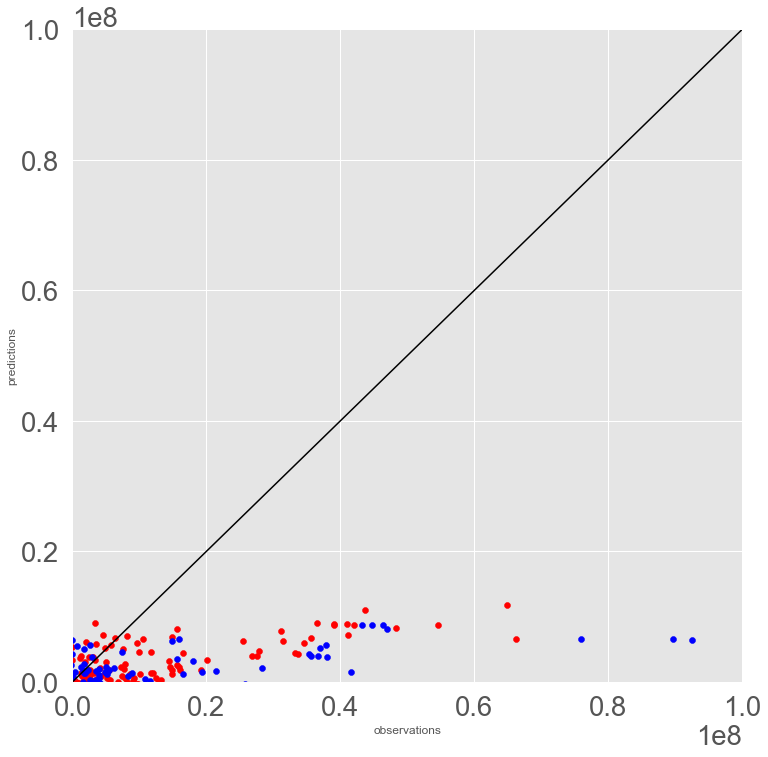

In [90]:
x = np.linspace(-100000000,100000000,100000000)
plt.figure(figsize=(12,12))
plt.scatter(y_train, aml.predict(training_frame).as_data_frame()['predict'].values, c='red')
plt.scatter(y_test, aml.predict(testing_frame).as_data_frame()['predict'].values, c='blue')
#plt.scatter(train_df['voyage_duration'], train_df['eta_diff'], c='green')
plt.plot(x,x,c='black')
plt.xlim([-5,100000000])
plt.ylim([-5,100000000])
plt.xlabel('observations')
plt.ylabel('predictions')


In [91]:
aml.leader

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190829_164313_model_1

Status of Neuron Layers: predicting OA_Difference, regression, gaussian distribution, Quadratic loss, 91,851 weights/biases, 1.1 MB, 3,402,901 training samples, mini-batch size 1



layer    units    type              dropout    l1    l2    mean_rate              rate_rms              momentum    mean_weight            weight_rms           mean_bias           bias_rms
--  -------  -------  ----------------  ---------  ----  ----  ---------------------  --------------------  ----------  ---------------------  -------------------  ------------------  -----------------------
    1        1835     Input             15.0
    2        50       RectifierDropout  10.0       0.0   0.0   0.16992563438541167    0.32602739334106445   0.0         -0.005799886157729473  0.06239078938961029  2.8435765088185168  3.585627555847168
    3        1        Linear                       0.0   0.0   0.0020167277622158506  0.011540800333023071  0.0         -0.06542298311367631   0.20244449377059937  36.32925995853013   1.0971281125650402e-154



ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 13548935332146.191
RMSE: 3680887.8456353694
MAE: 3473292.0786550343
RMSLE: NaN
Mean Residual Deviance: 13548935332146.191

ModelMetricsRegression: deeplearning
** Reported on cross-validation data. **

MSE: 4934883947592.212
RMSE: 2221459.8685531574
MAE: 100080.62994660635
RMSLE: NaN
Mean Residual Deviance: 4934883947592.212
Cross-Validation Metrics Summary: 


mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     100082       15524.2      81346         113104        93756.7       76293.4       135908
mean_residual_deviance  4.93497e+12  2.45644e+12  1.23404e+12   1.04418e+13   5.67741e+12   1.15874e+12   6.16286e+12
mse                     4.93497e+12  2.45644e+12  1.23404e+12   1.04418e+13   5.67741e+12   1.15874e+12   6.16286e+12
r2                      0.102536     0.0260038    0.100689      0.044171      0.157585      0.0927004     0.117536
residual_deviance       4.93497e+12  2.45644e+12  1.23404e+12   1.04418e+13   5.67741e+12   1.15874e+12   6.16286e+12
rmse                    2.05679e+06  593545       1.11087e+06   3.23138e+06   2.38273e+06   1.07645e+06   2.48251e+06
rmsle                   0            nan          nan           nan           nan           nan           nan

Scoring History: 


timestamp            duration          training_speed    epochs               iterations    samples    training_rmse       training_deviance    training_mae        training_r2
---  -------------------  ----------------  ----------------  -------------------  ------------  ---------  ------------------  -------------------  ------------------  ---------------------
     2019-08-29 16:55:47  0.000 sec                           0.0                  0             0.0        nan                 nan                  nan                 nan
     2019-08-29 16:55:47  7 min 12.611 sec  33825 obs/sec     0.20407232235960077  1             21919.0    1089150.6549939972  1186249149273.853    119753.27252238232  -0.041399323618233064
     2019-08-29 16:55:53  7 min 17.795 sec  39271 obs/sec     2.037641516460599    10            218859.0   1128526.4123684212  1273571863413.14     107302.53868845484  -0.11805928623808226
     2019-08-29 16:55:58  7 min 22.814 sec  38107 obs/sec     3.674605243557277    18            394682.0   1219816.174856021   1487951500440.3748   92731.47586591504   -0.306261578424633
     2019-08-29 16:56:03  7 min 28.056 sec  38607 obs/sec     5.512848204975421    27            592124.0   1343904.5818633977  1806079525153.434    85030.97854153594   -0.5855438101235846
---  ---                  ---               ---               ---                  ---           ---        ---                 ---                  ---                 ---
     2019-08-29 16:57:13  8 min 38.069 sec  33471 obs/sec     25.549000074482347   125           2744167.0  1473926.433301143   2172459130783.8293   87195.11609138994   -0.907185746578981
     2019-08-29 16:57:18  8 min 43.458 sec  33513 obs/sec     27.18417622523462    133           2919798.0  1383812.781320541   1914937813746.0913   85231.95907158034   -0.6811096937155994
     2019-08-29 16:57:24  8 min 48.805 sec  33814 obs/sec     29.022959183673468   142           3117298.0  1221929.7456744758  1493112303364.0889   97557.94266414951   -0.31079220900706384
     2019-08-29 16:57:29  8 min 54.034 sec  33890 obs/sec     30.655975346342917   150           3292697.0  3387305.489885619   11473838481809.254   3026399.9482178977  -9.072797642531793
     2019-08-29 16:57:33  8 min 58.398 sec  33610 obs/sec     31.682006926858335   155           3402901.0  3680887.8456353694  13548935332146.191   3473292.0786550343  -10.894509765744731


See the whole table with table.as_data_frame()
Variable Importances: 


variable                                             relative_importance    scaled_importance    percentage
---------------------------------------------------  ---------------------  -------------------  ---------------------
Original Budget                                      1.0                    1.0                  0.003934636851477281
Fund Center Name.HAS-IAH-Management                  0.7112650871276855     0.7112650871276855   0.0027985698229817907
Revenue or Expenditure.Expenditures                  0.6524217128753662     0.6524217128753662   0.0025670425141833455
GL Category Description.550 - Non-Capital Purchases  0.638657808303833      0.638657808303833    0.0025128865480359744
GL Category Description.500 - Personnel Services     0.6323221921920776     0.6323221921920776   0.002487958199405849
---                                                  ---                    ---                  ---
GL Category Description.missing(NA)                  0.0                    0.0                  0.0
Business Area Name.missing(NA)                       0.0                    0.0                  0.0
Fund Type Descr.missing(NA)                          0.0                    0.0                  0.0
Commitment Set Description.missing(NA)               0.0                    0.0                  0.0
Revenue or Expenditure.missing(NA)                   0.0                    0.0                  0.0


See the whole table with table.as_data_frame()


In [92]:
a = np.random.random(50)
print(a)
print(a[::3])

[0.48669735 0.89815765 0.24847341 0.47148232 0.65756053 0.9509482
 0.53600104 0.29472501 0.02315856 0.30829425 0.17298949 0.64857232
 0.85634284 0.24799426 0.85502617 0.72330275 0.91903542 0.47590504
 0.88684697 0.0803223  0.22562915 0.02204716 0.57656745 0.32135726
 0.26423228 0.65117068 0.94585457 0.9499369  0.34231672 0.5682143
 0.09897431 0.38473951 0.08113423 0.70357256 0.40580126 0.65353686
 0.98753065 0.64120145 0.18096296 0.11588839 0.25505791 0.25371583
 0.53349469 0.83390792 0.37388502 0.09161452 0.47984337 0.34934149
 0.72034542 0.08647331]
[0.48669735 0.47148232 0.53600104 0.30829425 0.85634284 0.72330275
 0.88684697 0.02204716 0.26423228 0.9499369  0.09897431 0.70357256
 0.98753065 0.11588839 0.53349469 0.09161452 0.72034542]


In [93]:
df['OA_Difference'].describe()

count     196709.0
unique    130376.0
top            0.0
freq       22037.0
Name: OA_Difference, dtype: float64

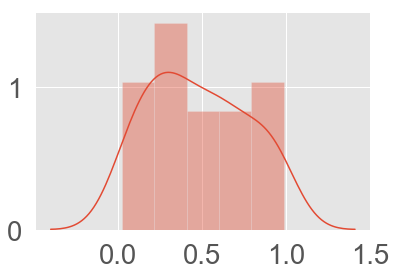

In [94]:
sns.distplot(a)

In [98]:
df['OA_Difference'].shape

(196709,)

In [109]:
len(df.loc[(df['OA_Difference']<=1.0) & (df['OA_Difference']>=-1.0)]['OA_Difference'])

24002

In [95]:
df['OA_Difference'].value_counts()

 0.000000e+00    22037
-1.000000e+02     1789
-5.000000e+02     1704
-2.000000e+02     1582
-1.000000e+03     1561
-3.000000e+02     1002
-2.000000e+03      888
-4.000000e+02      623
-5.000000e+03      608
-6.000000e+02      509
-1.500000e+03      461
-3.000000e+03      418
-8.000000e+02      315
-1.000000e+04      308
-2.500000e+03      296
-2.500000e+02      229
-4.000000e+03      227
-7.000000e+02      223
-1.200000e+03      207
-9.000000e+02      181
-7.000000e+01      180
-6.000000e+03      169
 3.500000e+01      131
-1.050000e+02      124
-2.800000e-01      122
-3.500000e+01      119
-1.400000e+02      119
-1.100000e+03      116
-1.750000e+02      113
-3.500000e+03      110
-5.000000e+01      108
-2.000000e+04      108
-2.800000e+02      107
-5.600000e-01      106
-1.500000e+02      105
-5.000000e+04      104
-1.500000e+04      103
 5.000000e+02      100
-2.500000e+04       92
-1.300000e+03       89
-1.800000e+03       89
 1.000000e+02       88
-1.600000e+03       85
-1.700000e+

In [37]:
OA_Diff = df['OA_Difference']

(-80000000.0, 80000000.0)

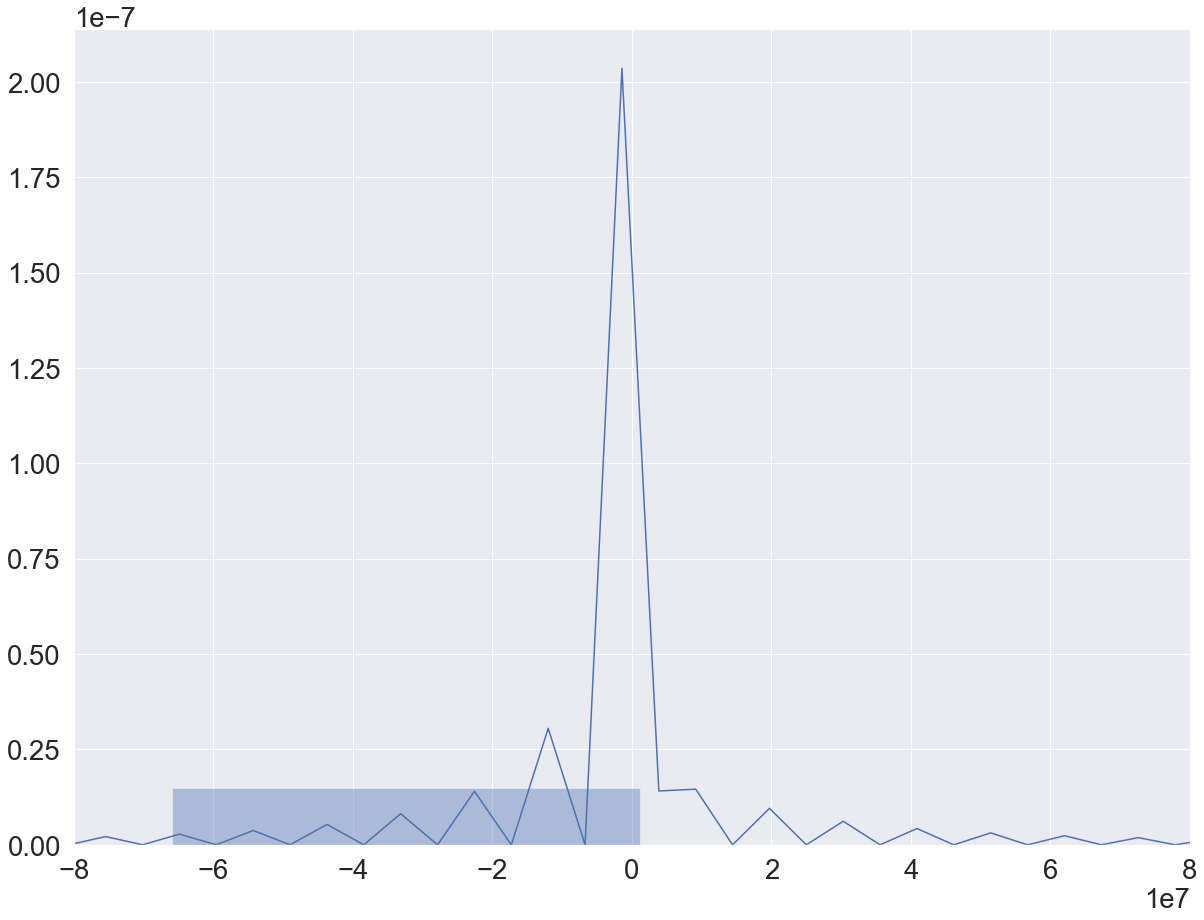

In [75]:
#Seaborn distplot
sns.set_style('darkgrid')
sns.set(font_scale=2.5)

fig, ax = plt.subplots(figsize=(20,15))
sns.distplot(list(OA_Diff),bins=10, ax=ax)

ax.set_xlim(-8e7,8e7)
#ax.set(xticks=[-40000000, -20000000,0, 20000000, 40000000])

# ax.set_title("32 Different Teachers - Intro to Financing \n Grade Distriubtions Room 2170")
# ax.set_ylabel("Frequency")
# ax.set_xlabel("Percent A's Given")

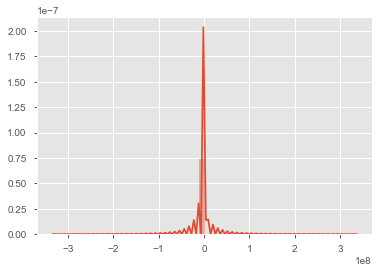

In [62]:
sns.distplot(list(OA_Diff))

In [ ]:
df['OA_Difference'].max()

In [ ]:
df['OA_Difference'].std()

In [ ]:
df['OA_Difference'].min()

In [ ]:
df['Original Budget'].std()

In [ ]:
df['Original Budget'].min()

In [ ]:
df.loc[df['Original Budget']==df['Original Budget'].min()]

In [ ]:
(df.loc[df['Original Budget']>0]['OA_Difference'].values).std()

In [ ]:
original_df = df.copy(deep=True)

In [ ]:
df = df.loc[df['Original Budget']>0]

In [ ]:
#plt.hist(df['OA_Difference'].values)

In [ ]:
%%capture --no-display
pandas_profiling.ProfileReport(df)

In [ ]:
plt.hist(df['OA_Difference'].values)